# Inference in Graphical Models

The marginal inference of a graphical model is seeked to answer a question about a random variable of the graph. More specifically,

$$
    p(y\in D) = \sum_{x_1}\sum_{x_2}\cdots\sum_{x_N}p(y\in D, x_1, x_2, \ldots, x_N)
$$

* Inference is often an NP-hard problem
* Tractability of the inference is dependent on the structure of the graph that describs that probability

----

## Variable Elimination on a Chain
Consider a Markov Random Field with discrete random variables $\{x_n\}_{n=1}^N$ taking $K$ elements each. The join probability of this

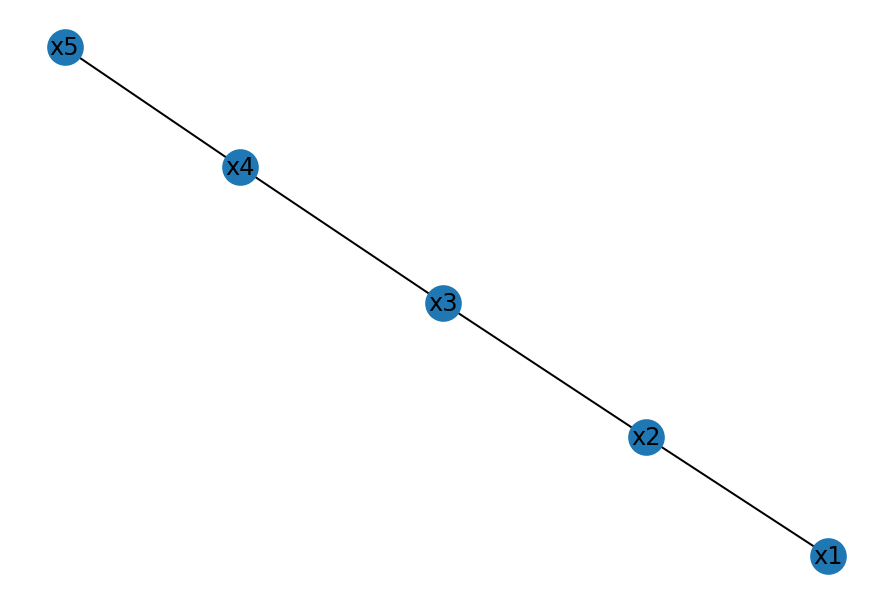

In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = "retina"

G = nx.Graph()
G.add_node("x1")
G.add_node("x2")
G.add_node("x3")
G.add_node("x4")
G.add_node("x5")

G.add_edges_from([("x1", "x2"), ("x2", "x3"), ("x3", "x4"), ("x4", "x5")])
nx.draw(G, labels={node:node for node in G.nodes})

Each of the elements in the following dictionary represent the potential functions $\psi_C({\bf x_C})$ for each maximal clique $C$ which, in this case, is given by any two consecutive nodes

In [2]:
potentials = {
    (1,2): np.array([
        [0.7, 0.8],
        [0.1, 0.3]
    ]),
    (2, 3): np.array([
        [0.2, 0.5],
        [0.5, 0.3]
    ]),
    (3, 4): np.array([
        [0.9, 0.9],
        [0.5, 0.7]
    ]),
    (4, 5): np.array([
        [0.7, 0.1],
        [0.7, 0.8]
    ])
}

### Computing $p(x_3)$
#### The Inefficient Way

$$
    p(x_j = i) = \sum_{x_1}\cdots\sum_{x_j-1}\sum_{x_j+1}\cdots\sum_{x_N}p(x_1, x_2, \ldots, x_N)
$$

In [3]:
from itertools import product

In [4]:
Z = 0
vals = [0, 1]
for x1, x2, x3, x4, x5 in product(*[vals] * 5):
    Z += (potentials[1,2][x1, x2] * potentials[2, 3][x2, x3] * 
          potentials[3, 4][x3, x4] * potentials[4, 5][x4, x5])
Z

2.528200000000001

In [5]:
px3 = []
for x3 in vals:
    px3_i = 0
    for x1, x2, x4, x5 in product(*[vals] * 4):
        px3_i += (potentials[1, 2][x1, x2] * potentials[2, 3][x2, x3] * 
                  potentials[3, 4][x3, x4] * potentials[4, 5][x4, x5])
    px3_i /= Z
    px3.append(px3_i)

In [6]:
sum(px3)

0.9999999999999996

In [7]:
px3

[0.5813226801677082, 0.41867731983229145]

#### The forward/backward - passing way

**Forward-passing equations**  
$\sum_{x_{j-1}} \psi_{j-1, j}(x_{j-1}, x_j) =$  `potentials[j - 1, j].sum(axis=0)`

**Backward-passing equations**  
$\sum_{x_{j+1}} \psi_{j, j+1}(x_j, x_{j+1}) =$  `potentials[j, j + 1].sum(axis=1)`

In [8]:
# Forward-passing message
mu_alpha = potentials[1,2].sum(axis=0, keepdims=True).T 
mu_alpha = (potentials[2,3] * mu_alpha).sum(axis=0)
mu_alpha

array([0.71, 0.73])

In [9]:
# Backward-passing message
mu_beta = potentials[4, 5].sum(axis=1)
mu_beta = (potentials[3, 4] * mu_beta).sum(axis=1)
mu_beta

array([2.07, 1.45])

In [10]:
px3 = mu_alpha * mu_beta / Z
px3.sum()

0.9999999999999998

In [11]:
px3

array([0.58132268, 0.41867732])

In [12]:
def forward_pass(potential_vals, limit):
    mu_alpha = 1.0
    for i in range(limit - 1):
        xi, xj = i + 1, i + 2
        mu_alpha  = (potential_vals[xi, xj] * mu_alpha).sum(axis=0, keepdims=True).T
    return mu_alpha

In [13]:
# An alternate way to compute Z
forward_pass(potentials, 5).sum()

2.5282